# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

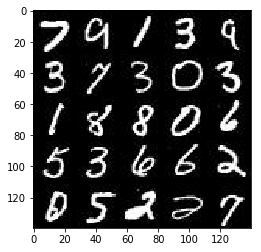

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

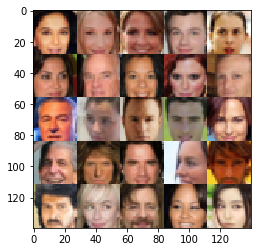

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # Input image placeholder from 
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels)
                                       , name='real_input_images')
    
    # Noise vector placeholder
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    
    # Learning rate placeholder
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (real_input_images, z_inputs, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [7]:
# Define Leaky Relu Function
def l_relu(tensor, alpha=0.1):
    return tf.maximum(alpha * tensor, tensor)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False, alpha=0.1, start_depth=64, dropout_keep_prob=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
                
        # Dont use activation/bias when using batch normalization and and leaky Relu's
        
        # Input layer is 28x28x3
        conv_1 = tf.layers.conv2d(images, start_depth, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        leaky_relu_1 = l_relu(conv_1, alpha)
        #drop_1 = tf.nn.dropout(leaky_relu_1, dropout_keep_prob)
            
        # 14x14xstart_depth*2^0
        conv_2 = tf.layers.conv2d(leaky_relu_1, start_depth*2, 5, strides=2, padding='same', use_bias=True,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm_2 = tf.layers.batch_normalization(conv_2, training=True)
        leaky_relu_2 = l_relu(norm_2, alpha)
        #drop_2 = tf.nn.dropout(leaky_relu_2, dropout_keep_prob)
        
        # 7x7xstart_depth*2^1
        conv_3 = tf.layers.conv2d(leaky_relu_2, start_depth*4, 5, strides=2, padding='same', use_bias=True,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm_3 = tf.layers.batch_normalization(conv_3, training=True)
        leaky_relu_3 = l_relu(norm_3, alpha)
        drop_3 = tf.nn.dropout(leaky_relu_3, dropout_keep_prob)
        
        # Output layer is 4x4xstart_depth*2^2
        
        final_image_size = int(drop_3.get_shape()[1])
        #print(final_image_size)
        
        flattened_size = final_image_size*final_image_size*start_depth*4
                
        # Flatten layer to be fully connected to logits - tf.nn.relu
        flattened = tf.reshape(drop_3, (-1, flattened_size))
        dense_1 = tf.nn.dropout(tf.layers.dense(flattened, 4*start_depth*4, activation=None, use_bias=True),
                               dropout_keep_prob)
        #norm_4 = tf.layers.batch_normalization(dense_1, training=True)
        leaky_relu_4 = l_relu(dense_1, alpha)
        logits = tf.layers.dense(leaky_relu_4, 1, activation=None)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, start_depth=512, dropout_keep_prob=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # First fully connected layer
        dense_in = tf.layers.dense(z, 7*7*start_depth, 
                                              activation=None, use_bias=True)
        
        # Reshape it to start the convolutional stack
        dense_out = tf.reshape(dense_in, (-1, 7, 7, start_depth))
        dense_norm_1 = tf.layers.batch_normalization(dense_out, training=is_train)
        leaky_relu_1 = l_relu(dense_norm_1, alpha)
        
        # Input to layer has shape: 7x7xstart_depth
        conv_1 = tf.layers.conv2d_transpose(leaky_relu_1, start_depth//2, 5, strides=2, padding='same',
                                           use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        leaky_relu_2 = l_relu(norm_1, alpha)
        
        #print(leaky_relu_2.get_shape()[1]) - 13
        
        # Input to layer has shape: 14x14xstart_depth/2
        conv_2 = tf.layers.conv2d_transpose(leaky_relu_2, start_depth//4, 5, strides=2, padding='same',
                                           use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        leaky_relu_3 = tf.nn.dropout(l_relu(norm_2, alpha), dropout_keep_prob)
        
        
        #print(logits.get_shape()[1])
        
        # Final convolution - input to layer has shape: 28x28xstart_depth/4
        logits = tf.layers.conv2d_transpose(leaky_relu_3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        
         # 28x28xoutput_dim for output 
        #logits = tf.image.resize_nearest_neighbor(conv_3, (28,28))
        
        # print(logits.get_shape()[1], logits.get_shape()[2], logits.get_shape()[3])
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1, label_smoothing=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Discriminator model classification for real image inputs
    discriminator_model_real, discriminator_logits_real = discriminator(input_real, reuse=False, alpha=alpha)

    # Generator model that creates counterfeit images
    generator_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
   
    # Discriminator model classification for counterfeit image inputs
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True, alpha=alpha)

    # Discriminator loss for real images
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, 
                                                labels=tf.ones_like(discriminator_model_real)*(1-label_smoothing)))
    
    # Discriminator loss for counterfeit images
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, 
                                                labels=tf.zeros_like(discriminator_model_fake)))
    
    # Total discriminator loss from real and fake image classification
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    # Generator loss - how close to tricking discriminator (variance from discrimintor output of ~1)
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, 
                                                labels=tf.ones_like(discriminator_model_fake)))

    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get all trainable weights and biases
    all_training_vars = tf.trainable_variables()
    
    # Identify trainable variables associated with the discriminator
    discriminator_vars = [var for var in all_training_vars if var.name.startswith('discriminator')]
    
    # Identify trainable variables associated with the generator
    generator_vars = [var for var in all_training_vars if var.name.startswith('generator')]
    
    
    # Get discriminator updates ops
    discriminator_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    #print(discriminator_update_ops)
    
    # Update the batch norm statistics before training optimization
    with tf.control_dependencies(discriminator_update_ops):
        
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, 
                                                                                  var_list=discriminator_vars)
    
    # Get generator update ops
    generator_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    # Update the batch norm statistics before training optimization
    with tf.control_dependencies(generator_update_ops):
        
        generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, 
                                                                                  var_list=generator_vars)
        
    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Set the number of times to run the generator optimization for each batch
    generator_runs = 1
    
    # Set data output parameters 
    print_every = 25
    show_every = 250
    view_image_count = 36
    
    # Get image dimensions
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channel_dim = data_shape[3]
    
    # Get placeholders    
    real_input_images, z_inputs, learn_rate_placeholder = model_inputs(image_width, image_height, 
                                                                       image_channel_dim, z_dim)

    # Get discriminator and generator loss tensors
    discriminator_loss, generator_loss = model_loss(real_input_images, z_inputs, image_channel_dim)

    # Get discriminator and generator optimization tensors
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learn_rate_placeholder, beta1)   
  
    # Initialize step counter to dicate loss and image display 
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Rescale image to -1 to 1
                batch_images = batch_images * 2
                
                # Update Batch Count
                batch_count += 1

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run discriminator optimizer
                _ = sess.run(discriminator_opt, feed_dict={real_input_images: batch_images, 
                                                           z_inputs: batch_z,
                                                          learn_rate_placeholder : learning_rate})
                
                '''
                    https://discussions.udacity.com/t/...
                        why-does-multiple-iterations-of-generator-model-optimization-per-batch-work-better/248392 
                '''
                # Run the generator optimizer multiple times per batch to maintain generator superiority
                for gen_i in range(generator_runs):
                    _ = sess.run(generator_opt, feed_dict={real_input_images: batch_images,
                                                           z_inputs: batch_z, 
                                                           learn_rate_placeholder : learning_rate})
                    
                # Evaluate loss values to be displayed 
                if batch_count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_discriminator = discriminator_loss.eval(
                        {real_input_images: batch_images, z_inputs: batch_z})
                    
                    train_loss_generator = generator_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}, ".format(epoch_i, epoch_count),
                          "Batch {}, ".format(batch_count),
                          "Discriminator Loss: {:.4f}, ".format(train_loss_discriminator),
                          "Generator Loss: {:.4f}".format(train_loss_generator))
                    
                    # Save losses to QC training
                    #losses.append((train_loss_discriminator, train_loss_generator))

                # Generate sample output images to evaluate image quality
                if batch_count % show_every == 0:
                    show_generator_output(sess, view_image_count, z_inputs, image_channel_dim, data_image_mode)
                                 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2,  Batch 25,  Discriminator Loss: 0.3496,  Generator Loss: 6.5568
Epoch 0/2,  Batch 50,  Discriminator Loss: 0.3419,  Generator Loss: 9.2368
Epoch 0/2,  Batch 75,  Discriminator Loss: 0.3430,  Generator Loss: 10.1561
Epoch 0/2,  Batch 100,  Discriminator Loss: 0.3451,  Generator Loss: 9.4063
Epoch 0/2,  Batch 125,  Discriminator Loss: 0.3446,  Generator Loss: 9.9536
Epoch 0/2,  Batch 150,  Discriminator Loss: 0.9021,  Generator Loss: 1.7333
Epoch 0/2,  Batch 175,  Discriminator Loss: 1.2794,  Generator Loss: 0.9724
Epoch 0/2,  Batch 200,  Discriminator Loss: 1.1256,  Generator Loss: 1.3144
Epoch 0/2,  Batch 225,  Discriminator Loss: 0.9976,  Generator Loss: 1.1323
Epoch 0/2,  Batch 250,  Discriminator Loss: 1.2971,  Generator Loss: 0.7809


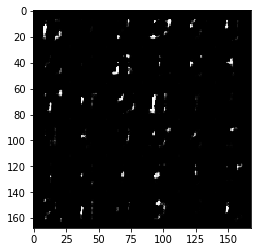

Epoch 0/2,  Batch 275,  Discriminator Loss: 1.5217,  Generator Loss: 1.3767
Epoch 0/2,  Batch 300,  Discriminator Loss: 1.3660,  Generator Loss: 1.6397
Epoch 0/2,  Batch 325,  Discriminator Loss: 1.4753,  Generator Loss: 0.5481
Epoch 0/2,  Batch 350,  Discriminator Loss: 1.2639,  Generator Loss: 0.8491
Epoch 0/2,  Batch 375,  Discriminator Loss: 1.2253,  Generator Loss: 1.5050
Epoch 0/2,  Batch 400,  Discriminator Loss: 1.4470,  Generator Loss: 0.5829
Epoch 0/2,  Batch 425,  Discriminator Loss: 1.4239,  Generator Loss: 0.6445
Epoch 0/2,  Batch 450,  Discriminator Loss: 1.2509,  Generator Loss: 1.3059
Epoch 0/2,  Batch 475,  Discriminator Loss: 1.1691,  Generator Loss: 1.0035
Epoch 0/2,  Batch 500,  Discriminator Loss: 1.3753,  Generator Loss: 1.0803


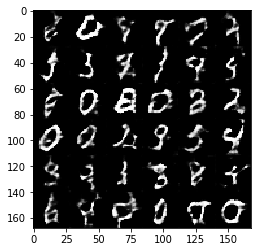

Epoch 0/2,  Batch 525,  Discriminator Loss: 1.2892,  Generator Loss: 0.9920
Epoch 0/2,  Batch 550,  Discriminator Loss: 1.3489,  Generator Loss: 0.9729
Epoch 0/2,  Batch 575,  Discriminator Loss: 1.1659,  Generator Loss: 1.1414
Epoch 0/2,  Batch 600,  Discriminator Loss: 1.3475,  Generator Loss: 0.5517
Epoch 0/2,  Batch 625,  Discriminator Loss: 1.1774,  Generator Loss: 1.2166
Epoch 0/2,  Batch 650,  Discriminator Loss: 1.4225,  Generator Loss: 0.6930
Epoch 0/2,  Batch 675,  Discriminator Loss: 1.2773,  Generator Loss: 1.1449
Epoch 0/2,  Batch 700,  Discriminator Loss: 1.1941,  Generator Loss: 1.0575
Epoch 0/2,  Batch 725,  Discriminator Loss: 1.1785,  Generator Loss: 0.8016
Epoch 0/2,  Batch 750,  Discriminator Loss: 1.1836,  Generator Loss: 1.2991


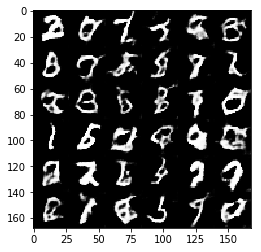

Epoch 0/2,  Batch 775,  Discriminator Loss: 1.2002,  Generator Loss: 1.0588
Epoch 0/2,  Batch 800,  Discriminator Loss: 1.2220,  Generator Loss: 1.1361
Epoch 0/2,  Batch 825,  Discriminator Loss: 1.1912,  Generator Loss: 1.1015
Epoch 0/2,  Batch 850,  Discriminator Loss: 1.1144,  Generator Loss: 1.1264
Epoch 0/2,  Batch 875,  Discriminator Loss: 1.1722,  Generator Loss: 0.8614
Epoch 0/2,  Batch 900,  Discriminator Loss: 1.4239,  Generator Loss: 1.8459
Epoch 0/2,  Batch 925,  Discriminator Loss: 1.1769,  Generator Loss: 1.0635
Epoch 1/2,  Batch 950,  Discriminator Loss: 1.2448,  Generator Loss: 0.7674
Epoch 1/2,  Batch 975,  Discriminator Loss: 1.2541,  Generator Loss: 1.1184
Epoch 1/2,  Batch 1000,  Discriminator Loss: 1.2296,  Generator Loss: 0.8293


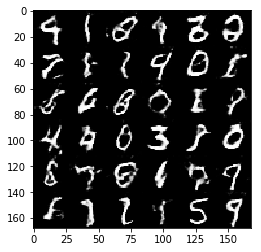

Epoch 1/2,  Batch 1025,  Discriminator Loss: 1.3905,  Generator Loss: 0.9989
Epoch 1/2,  Batch 1050,  Discriminator Loss: 1.1854,  Generator Loss: 0.9883
Epoch 1/2,  Batch 1075,  Discriminator Loss: 1.1291,  Generator Loss: 1.0914
Epoch 1/2,  Batch 1100,  Discriminator Loss: 1.1559,  Generator Loss: 1.0349
Epoch 1/2,  Batch 1125,  Discriminator Loss: 1.2918,  Generator Loss: 0.8299
Epoch 1/2,  Batch 1150,  Discriminator Loss: 1.2952,  Generator Loss: 1.0661
Epoch 1/2,  Batch 1175,  Discriminator Loss: 1.1869,  Generator Loss: 1.0435
Epoch 1/2,  Batch 1200,  Discriminator Loss: 1.3365,  Generator Loss: 0.6388
Epoch 1/2,  Batch 1225,  Discriminator Loss: 1.2387,  Generator Loss: 0.8050
Epoch 1/2,  Batch 1250,  Discriminator Loss: 1.1376,  Generator Loss: 1.1086


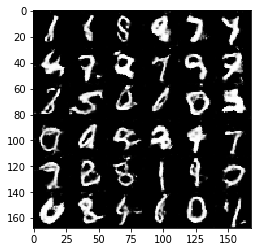

Epoch 1/2,  Batch 1275,  Discriminator Loss: 1.3196,  Generator Loss: 0.8672
Epoch 1/2,  Batch 1300,  Discriminator Loss: 1.2228,  Generator Loss: 0.8916
Epoch 1/2,  Batch 1325,  Discriminator Loss: 1.2132,  Generator Loss: 1.0432
Epoch 1/2,  Batch 1350,  Discriminator Loss: 1.1106,  Generator Loss: 1.8924
Epoch 1/2,  Batch 1375,  Discriminator Loss: 1.2006,  Generator Loss: 1.9444
Epoch 1/2,  Batch 1400,  Discriminator Loss: 1.1839,  Generator Loss: 1.0444
Epoch 1/2,  Batch 1425,  Discriminator Loss: 1.0917,  Generator Loss: 0.9153
Epoch 1/2,  Batch 1450,  Discriminator Loss: 1.2540,  Generator Loss: 0.7830
Epoch 1/2,  Batch 1475,  Discriminator Loss: 1.1618,  Generator Loss: 1.2780
Epoch 1/2,  Batch 1500,  Discriminator Loss: 1.1830,  Generator Loss: 0.9456


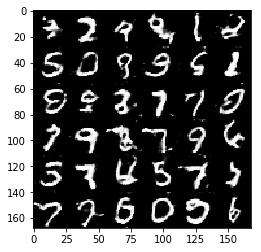

Epoch 1/2,  Batch 1525,  Discriminator Loss: 1.2823,  Generator Loss: 0.7734
Epoch 1/2,  Batch 1550,  Discriminator Loss: 1.0572,  Generator Loss: 1.0656
Epoch 1/2,  Batch 1575,  Discriminator Loss: 1.2974,  Generator Loss: 0.7871
Epoch 1/2,  Batch 1600,  Discriminator Loss: 1.1206,  Generator Loss: 0.9935
Epoch 1/2,  Batch 1625,  Discriminator Loss: 1.0945,  Generator Loss: 1.2419
Epoch 1/2,  Batch 1650,  Discriminator Loss: 1.0102,  Generator Loss: 1.1906
Epoch 1/2,  Batch 1675,  Discriminator Loss: 1.0107,  Generator Loss: 1.8211
Epoch 1/2,  Batch 1700,  Discriminator Loss: 1.1023,  Generator Loss: 1.0019
Epoch 1/2,  Batch 1725,  Discriminator Loss: 1.0311,  Generator Loss: 1.3277
Epoch 1/2,  Batch 1750,  Discriminator Loss: 0.9821,  Generator Loss: 1.6915


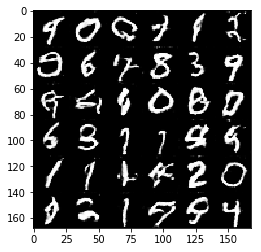

Epoch 1/2,  Batch 1775,  Discriminator Loss: 1.4443,  Generator Loss: 0.5826
Epoch 1/2,  Batch 1800,  Discriminator Loss: 1.2981,  Generator Loss: 2.2934
Epoch 1/2,  Batch 1825,  Discriminator Loss: 0.8031,  Generator Loss: 1.6164
Epoch 1/2,  Batch 1850,  Discriminator Loss: 1.5488,  Generator Loss: 3.0914


In [42]:
batch_size = 64
z_dim = 100
learning_rate = .002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1,  Batch 25,  Discriminator Loss: 4.8143,  Generator Loss: 0.0296
Epoch 0/1,  Batch 50,  Discriminator Loss: 0.6936,  Generator Loss: 2.3006
Epoch 0/1,  Batch 75,  Discriminator Loss: 0.9686,  Generator Loss: 5.1770
Epoch 0/1,  Batch 100,  Discriminator Loss: 0.4236,  Generator Loss: 4.7928
Epoch 0/1,  Batch 125,  Discriminator Loss: 0.7790,  Generator Loss: 1.5520
Epoch 0/1,  Batch 150,  Discriminator Loss: 0.7146,  Generator Loss: 1.8380
Epoch 0/1,  Batch 175,  Discriminator Loss: 1.0063,  Generator Loss: 1.2383
Epoch 0/1,  Batch 200,  Discriminator Loss: 3.9853,  Generator Loss: 0.0454
Epoch 0/1,  Batch 225,  Discriminator Loss: 1.0284,  Generator Loss: 1.0123
Epoch 0/1,  Batch 250,  Discriminator Loss: 1.0765,  Generator Loss: 0.7717


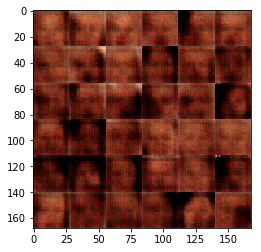

Epoch 0/1,  Batch 275,  Discriminator Loss: 0.8904,  Generator Loss: 1.3052
Epoch 0/1,  Batch 300,  Discriminator Loss: 1.6800,  Generator Loss: 3.6619
Epoch 0/1,  Batch 325,  Discriminator Loss: 1.3224,  Generator Loss: 3.3579
Epoch 0/1,  Batch 350,  Discriminator Loss: 0.9823,  Generator Loss: 1.7689
Epoch 0/1,  Batch 375,  Discriminator Loss: 1.0391,  Generator Loss: 1.0700
Epoch 0/1,  Batch 400,  Discriminator Loss: 1.0626,  Generator Loss: 1.1024
Epoch 0/1,  Batch 425,  Discriminator Loss: 1.0652,  Generator Loss: 1.2097
Epoch 0/1,  Batch 450,  Discriminator Loss: 0.9883,  Generator Loss: 1.3824
Epoch 0/1,  Batch 475,  Discriminator Loss: 1.1261,  Generator Loss: 1.3884
Epoch 0/1,  Batch 500,  Discriminator Loss: 1.0854,  Generator Loss: 1.3754


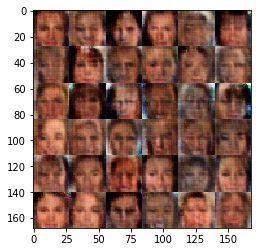

Epoch 0/1,  Batch 525,  Discriminator Loss: 1.2716,  Generator Loss: 1.8952
Epoch 0/1,  Batch 550,  Discriminator Loss: 1.1391,  Generator Loss: 1.1033
Epoch 0/1,  Batch 575,  Discriminator Loss: 1.1874,  Generator Loss: 1.8908
Epoch 0/1,  Batch 600,  Discriminator Loss: 1.3498,  Generator Loss: 1.1646
Epoch 0/1,  Batch 625,  Discriminator Loss: 1.1572,  Generator Loss: 1.1775
Epoch 0/1,  Batch 650,  Discriminator Loss: 1.1560,  Generator Loss: 0.8923
Epoch 0/1,  Batch 675,  Discriminator Loss: 1.2964,  Generator Loss: 1.3463
Epoch 0/1,  Batch 700,  Discriminator Loss: 1.2077,  Generator Loss: 1.0234
Epoch 0/1,  Batch 725,  Discriminator Loss: 1.1580,  Generator Loss: 1.4947
Epoch 0/1,  Batch 750,  Discriminator Loss: 1.3446,  Generator Loss: 1.0301


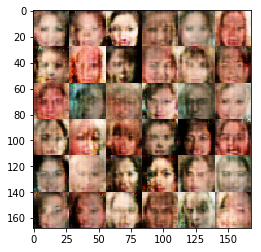

Epoch 0/1,  Batch 775,  Discriminator Loss: 1.2087,  Generator Loss: 1.0093
Epoch 0/1,  Batch 800,  Discriminator Loss: 1.2723,  Generator Loss: 1.4173
Epoch 0/1,  Batch 825,  Discriminator Loss: 1.3908,  Generator Loss: 0.9120
Epoch 0/1,  Batch 850,  Discriminator Loss: 1.0926,  Generator Loss: 0.9516
Epoch 0/1,  Batch 875,  Discriminator Loss: 1.3693,  Generator Loss: 1.0478
Epoch 0/1,  Batch 900,  Discriminator Loss: 1.2897,  Generator Loss: 0.8797
Epoch 0/1,  Batch 925,  Discriminator Loss: 1.3044,  Generator Loss: 1.0228
Epoch 0/1,  Batch 950,  Discriminator Loss: 1.3931,  Generator Loss: 0.9285
Epoch 0/1,  Batch 975,  Discriminator Loss: 1.2968,  Generator Loss: 1.0382
Epoch 0/1,  Batch 1000,  Discriminator Loss: 1.2727,  Generator Loss: 0.9121


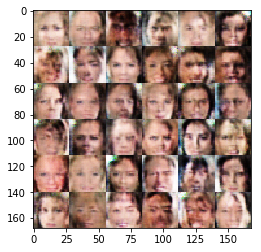

Epoch 0/1,  Batch 1025,  Discriminator Loss: 1.5282,  Generator Loss: 2.3108
Epoch 0/1,  Batch 1050,  Discriminator Loss: 1.3229,  Generator Loss: 0.9642
Epoch 0/1,  Batch 1075,  Discriminator Loss: 1.1921,  Generator Loss: 0.8880
Epoch 0/1,  Batch 1100,  Discriminator Loss: 1.3542,  Generator Loss: 0.8801
Epoch 0/1,  Batch 1125,  Discriminator Loss: 1.3245,  Generator Loss: 1.0168
Epoch 0/1,  Batch 1150,  Discriminator Loss: 1.3902,  Generator Loss: 0.8596
Epoch 0/1,  Batch 1175,  Discriminator Loss: 1.2633,  Generator Loss: 0.8579
Epoch 0/1,  Batch 1200,  Discriminator Loss: 1.3363,  Generator Loss: 0.8175
Epoch 0/1,  Batch 1225,  Discriminator Loss: 1.2845,  Generator Loss: 1.0190
Epoch 0/1,  Batch 1250,  Discriminator Loss: 1.2870,  Generator Loss: 1.1470


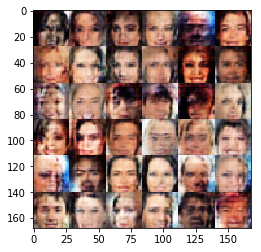

Epoch 0/1,  Batch 1275,  Discriminator Loss: 1.3005,  Generator Loss: 0.9806
Epoch 0/1,  Batch 1300,  Discriminator Loss: 1.3610,  Generator Loss: 0.9223
Epoch 0/1,  Batch 1325,  Discriminator Loss: 1.2650,  Generator Loss: 1.0088
Epoch 0/1,  Batch 1350,  Discriminator Loss: 1.4198,  Generator Loss: 0.6408
Epoch 0/1,  Batch 1375,  Discriminator Loss: 1.2345,  Generator Loss: 0.9716
Epoch 0/1,  Batch 1400,  Discriminator Loss: 1.2495,  Generator Loss: 1.0071
Epoch 0/1,  Batch 1425,  Discriminator Loss: 1.3019,  Generator Loss: 0.9096
Epoch 0/1,  Batch 1450,  Discriminator Loss: 1.4197,  Generator Loss: 0.6590
Epoch 0/1,  Batch 1475,  Discriminator Loss: 1.2640,  Generator Loss: 0.9945
Epoch 0/1,  Batch 1500,  Discriminator Loss: 1.2535,  Generator Loss: 0.9041


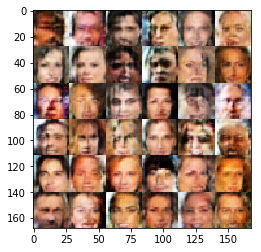

Epoch 0/1,  Batch 1525,  Discriminator Loss: 1.2459,  Generator Loss: 0.9427
Epoch 0/1,  Batch 1550,  Discriminator Loss: 1.3786,  Generator Loss: 0.8461
Epoch 0/1,  Batch 1575,  Discriminator Loss: 1.3541,  Generator Loss: 0.8613
Epoch 0/1,  Batch 1600,  Discriminator Loss: 1.2862,  Generator Loss: 1.0099
Epoch 0/1,  Batch 1625,  Discriminator Loss: 1.2272,  Generator Loss: 0.8714
Epoch 0/1,  Batch 1650,  Discriminator Loss: 1.2789,  Generator Loss: 0.7926
Epoch 0/1,  Batch 1675,  Discriminator Loss: 1.2955,  Generator Loss: 1.1523
Epoch 0/1,  Batch 1700,  Discriminator Loss: 1.3470,  Generator Loss: 1.0512
Epoch 0/1,  Batch 1725,  Discriminator Loss: 1.2282,  Generator Loss: 0.9852
Epoch 0/1,  Batch 1750,  Discriminator Loss: 1.3222,  Generator Loss: 0.8306


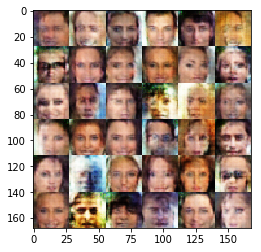

Epoch 0/1,  Batch 1775,  Discriminator Loss: 1.3112,  Generator Loss: 0.7867
Epoch 0/1,  Batch 1800,  Discriminator Loss: 1.3058,  Generator Loss: 0.9400
Epoch 0/1,  Batch 1825,  Discriminator Loss: 1.3237,  Generator Loss: 0.7992
Epoch 0/1,  Batch 1850,  Discriminator Loss: 1.2874,  Generator Loss: 0.8139
Epoch 0/1,  Batch 1875,  Discriminator Loss: 1.2811,  Generator Loss: 0.8870
Epoch 0/1,  Batch 1900,  Discriminator Loss: 1.3487,  Generator Loss: 0.7809
Epoch 0/1,  Batch 1925,  Discriminator Loss: 1.3128,  Generator Loss: 0.8853
Epoch 0/1,  Batch 1950,  Discriminator Loss: 1.3174,  Generator Loss: 0.9885
Epoch 0/1,  Batch 1975,  Discriminator Loss: 1.3231,  Generator Loss: 0.9948
Epoch 0/1,  Batch 2000,  Discriminator Loss: 1.4716,  Generator Loss: 0.8010


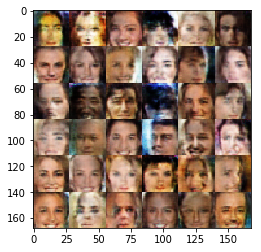

Epoch 0/1,  Batch 2025,  Discriminator Loss: 1.2949,  Generator Loss: 0.9205
Epoch 0/1,  Batch 2050,  Discriminator Loss: 1.4373,  Generator Loss: 0.6304
Epoch 0/1,  Batch 2075,  Discriminator Loss: 1.3393,  Generator Loss: 0.8257
Epoch 0/1,  Batch 2100,  Discriminator Loss: 1.2738,  Generator Loss: 0.9756
Epoch 0/1,  Batch 2125,  Discriminator Loss: 1.2003,  Generator Loss: 1.0147
Epoch 0/1,  Batch 2150,  Discriminator Loss: 1.3085,  Generator Loss: 0.9293
Epoch 0/1,  Batch 2175,  Discriminator Loss: 1.3712,  Generator Loss: 0.8241
Epoch 0/1,  Batch 2200,  Discriminator Loss: 1.3206,  Generator Loss: 0.7257
Epoch 0/1,  Batch 2225,  Discriminator Loss: 1.2814,  Generator Loss: 0.8693
Epoch 0/1,  Batch 2250,  Discriminator Loss: 1.3633,  Generator Loss: 0.8377


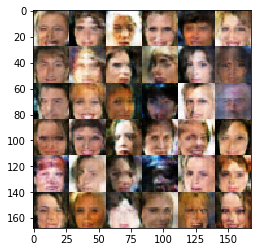

Epoch 0/1,  Batch 2275,  Discriminator Loss: 1.3981,  Generator Loss: 0.7899
Epoch 0/1,  Batch 2300,  Discriminator Loss: 1.3437,  Generator Loss: 0.8286
Epoch 0/1,  Batch 2325,  Discriminator Loss: 1.3453,  Generator Loss: 0.8513
Epoch 0/1,  Batch 2350,  Discriminator Loss: 1.2864,  Generator Loss: 0.8330
Epoch 0/1,  Batch 2375,  Discriminator Loss: 1.3415,  Generator Loss: 0.8674
Epoch 0/1,  Batch 2400,  Discriminator Loss: 1.2340,  Generator Loss: 0.8708
Epoch 0/1,  Batch 2425,  Discriminator Loss: 1.3204,  Generator Loss: 0.9679
Epoch 0/1,  Batch 2450,  Discriminator Loss: 1.2600,  Generator Loss: 0.8760
Epoch 0/1,  Batch 2475,  Discriminator Loss: 1.3686,  Generator Loss: 0.8404
Epoch 0/1,  Batch 2500,  Discriminator Loss: 1.2950,  Generator Loss: 0.7779


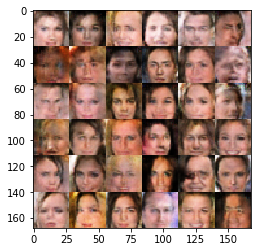

Epoch 0/1,  Batch 2525,  Discriminator Loss: 1.3611,  Generator Loss: 0.9482
Epoch 0/1,  Batch 2550,  Discriminator Loss: 1.3385,  Generator Loss: 0.8999
Epoch 0/1,  Batch 2575,  Discriminator Loss: 1.2917,  Generator Loss: 0.9030
Epoch 0/1,  Batch 2600,  Discriminator Loss: 1.3309,  Generator Loss: 0.8576
Epoch 0/1,  Batch 2625,  Discriminator Loss: 1.3107,  Generator Loss: 0.8768
Epoch 0/1,  Batch 2650,  Discriminator Loss: 1.3492,  Generator Loss: 0.9853
Epoch 0/1,  Batch 2675,  Discriminator Loss: 1.2041,  Generator Loss: 0.9028
Epoch 0/1,  Batch 2700,  Discriminator Loss: 1.3839,  Generator Loss: 0.8835
Epoch 0/1,  Batch 2725,  Discriminator Loss: 1.2842,  Generator Loss: 0.8445
Epoch 0/1,  Batch 2750,  Discriminator Loss: 1.3757,  Generator Loss: 0.7741


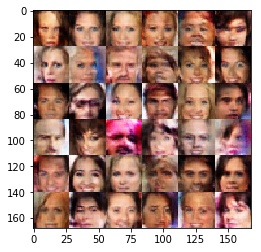

Epoch 0/1,  Batch 2775,  Discriminator Loss: 1.2877,  Generator Loss: 1.0195
Epoch 0/1,  Batch 2800,  Discriminator Loss: 1.3584,  Generator Loss: 0.8971
Epoch 0/1,  Batch 2825,  Discriminator Loss: 1.2363,  Generator Loss: 0.9290
Epoch 0/1,  Batch 2850,  Discriminator Loss: 1.4974,  Generator Loss: 0.6747
Epoch 0/1,  Batch 2875,  Discriminator Loss: 1.3746,  Generator Loss: 0.7235
Epoch 0/1,  Batch 2900,  Discriminator Loss: 1.2508,  Generator Loss: 0.8806
Epoch 0/1,  Batch 2925,  Discriminator Loss: 1.2824,  Generator Loss: 0.8425
Epoch 0/1,  Batch 2950,  Discriminator Loss: 1.2826,  Generator Loss: 0.8059
Epoch 0/1,  Batch 2975,  Discriminator Loss: 1.3810,  Generator Loss: 0.7932
Epoch 0/1,  Batch 3000,  Discriminator Loss: 1.3287,  Generator Loss: 0.9510


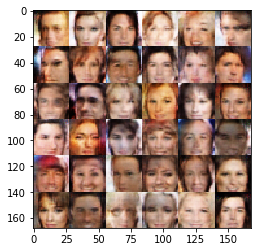

Epoch 0/1,  Batch 3025,  Discriminator Loss: 1.4209,  Generator Loss: 0.8802
Epoch 0/1,  Batch 3050,  Discriminator Loss: 1.2911,  Generator Loss: 0.9502
Epoch 0/1,  Batch 3075,  Discriminator Loss: 1.2949,  Generator Loss: 0.7471
Epoch 0/1,  Batch 3100,  Discriminator Loss: 1.3630,  Generator Loss: 0.8733
Epoch 0/1,  Batch 3125,  Discriminator Loss: 1.2644,  Generator Loss: 0.8442
Epoch 0/1,  Batch 3150,  Discriminator Loss: 1.2810,  Generator Loss: 0.8347


In [43]:
batch_size = 64
z_dim = 100
learning_rate = .0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.